# LSTM - Spam email detection
## G. Kementzidis
Let's create an LSTM network using PyTorch. The goal is to classify emails as either spam or not spam based on their text.

A lot of people have trained similar models to achieve this task: from simpler concepts like Naive Bayes to more complicated architectures like tranformers.

I found a labeled dataset on Kaggle with emails, and whether they are considered spam or not. You can find it here: https://www.kaggle.com/datasets/jackksoncsie/spam-email-dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# import string

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import LSTM, Linear
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

torch.manual_seed(1)

### Loading data

In [2]:
# loading data
data = pd.read_csv('emails.csv')

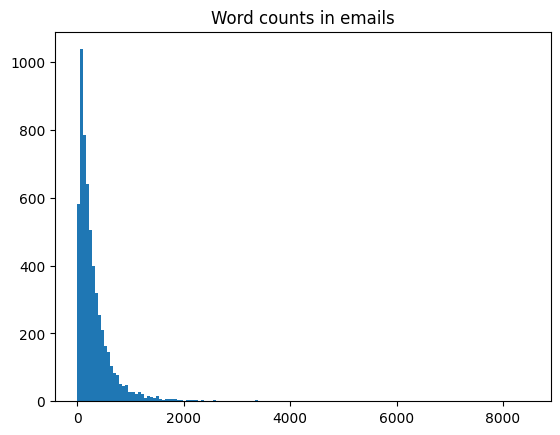

The longest email has 8477 words


In [3]:
# create a histogram with the length of each email
lengths = [len(data['text'][i].split()) for i in range(len(data['text']))]

plt.hist(lengths, bins=150)
plt.title('Word counts in emails')
plt.show()

max_length = max(lengths)
print('The longest email has', max_length, 'words')

### Pre-process the texts
- Remove punctuation
- Turn upper-case characters to lower-case

We will be using the first 100 words of the emails with at least 100 words.

In [4]:
num_words = 100

# remove punctuation and make all letters lowercase
# we use regular expressions
data['text_mod'] = data['text'].str.replace(r'[^a-zA-Z\s]', '', regex=True).str.lower()
more_than_100 = np.array([1 if len(data['text'][i].split()) > num_words else 0 for i in range(len(data['text']))])
data_hundred = data[more_than_100 == 1].reset_index(drop=True)

# get the first 100 words of each email
data_hundred['text_cut'] = data_hundred['text_mod'].str.split().apply(lambda x: x[:num_words]).str.join(' ')
data_hundred

,text,spam,text_mod,text_cut
0,Subject: naturally irresistible your corporate...,1,subject naturally irresistible your corporate ...,subject naturally irresistible your corporate ...
1,Subject: here ' s a hot play in motion homela...,1,subject here s a hot play in motion homeland...,subject here s a hot play in motion homeland s...
2,Subject: undeliverable : home based business f...,1,subject undeliverable home based business for...,subject undeliverable home based business for ...
3,Subject: las vegas high rise boom las vegas i...,1,subject las vegas high rise boom las vegas is...,subject las vegas high rise boom las vegas is ...
4,Subject: brighten those teeth get your teeth...,1,subject brighten those teeth get your teeth ...,subject brighten those teeth get your teeth br...
...,...,...,...,...
4321,Subject: re : research and development charges...,0,subject re research and development charges t...,subject re research and development charges to...
4322,"Subject: re : receipts from visit jim , than...",0,subject re receipts from visit jim thanks ...,subject re receipts from visit jim thanks agai...
4323,Subject: re : enron case study update wow ! a...,0,subject re enron case study update wow all ...,subject re enron case study update wow all on ...
4324,"Subject: re : interest david , please , call...",0,subject re interest david please call shi...,subject re interest david please call shirley ...


We make sure to remove duplicates and check whether our dataset is balanced. As you'll see later at the bottom of the notebook, during our first attempts, the dataset was unbalanced and the results were mixed. To balance it, we only kept 2/3 of the non-spam emails.


In [5]:
# remove duplicates and reset index
data_hundred = data_hundred.drop_duplicates().reset_index(drop=True)

In [6]:
data_hundred['spam'].value_counts()

spam
0    3438
1     861
Name: count, dtype: int64

In [7]:
# from data_hundred, keep only 2/3 of the non-spam emails
data_hundred = data_hundred.drop(data_hundred[data_hundred['spam'] == 0].sample(frac=1/3).index).reset_index(drop=True)
data_hundred['spam'].value_counts()

spam
0    2292
1     861
Name: count, dtype: int64

There is a variety of methods to deal with unbalanced datasets. In the case of images or numerical variables, you can conduct some sort of data augmentation, such as using reflections or rotations of images, SMOTE (synthetic minortiy over-sampling technique) for numerical data, etc. These cannot be easily applied to our model, because our input to the model is a text/string, whose words are carefully placed one after the other to convey a very specific meaning. Repeating words, bootstraping, or data-points interpolation isn't very meaningful.

### Creating word embeddings
We gather all unique words from the emails and we encode each one of them with a unique $x \in \mathbb{R}^{100}$. Whether the vector length is 100 or some other number (50, 150, 200, etc.) is a matter of choice. The word-length is a hyperparameter and we can try different values. 

We are using a pre-trained embedding called GloVe which respects the semantic and syntactic relationships between words. A previous attempt involved a random word embedding and there was little information learnt by the LSTM model.

[GloVe: Global Vectors for Word Representation](https://aclanthology.org/D14-1162) (Pennington et al., EMNLP 2014)

In [8]:
# Load GloVe embeddings
glove_path = 'glove.6B.100d.txt'
glove = {}
with open(glove_path, 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], 'float32')
        glove[word] = vector

In [9]:
word_length = 100

# create a dictionary of all unique words
word_dict = {}
num = 2
for i in range(len(data_hundred)):
    for word in data_hundred['text_cut'][i].split():
        if word not in word_dict:
            word_dict[word] = num
            num += 1

word_dict['<PAD>'] = 0 # padding
word_dict['<UNK>'] = 1 # unknown word

In [10]:
# create word embeddings for each word
# Create an embedding matrix
embedding_matrix = np.zeros((len(word_dict), word_length))
for word, i in word_dict.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.normal(scale=0.6, size=(word_length, ))

# Convert the embedding matrix to a tensor
embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)

# Create an embedding layer using the GloVe embeddings
word_embeddings = nn.Embedding.from_pretrained(embedding_matrix, freeze=False)

### Train-test split and create the Dataloaders

An important aspect of ML is to be able to train a data-driven model which can be applied to unseen data. 

A train-test split (80-20) lets us see whether we are dealing with either underfitting or overfitting.

In [11]:
# train - test split (80-20)
train = data_hundred.sample(frac=0.8, random_state=1)
test = data_hundred.drop(train.index)

train_reset = train.reset_index(drop=False)
test_reset = test.reset_index(drop=False)

# create a tensor with the labels
train_labels = torch.tensor(train_reset['spam'].to_numpy()).reshape(-1, 1)
test_labels = torch.tensor(test_reset['spam'].to_numpy()).reshape(-1, 1)

# create a tensor with the first num_words word embeddings of each email
train_tensor = torch.zeros(len(train), num_words, word_length)
test_tensor = torch.zeros(len(test), num_words, word_length)

In [12]:
for i in range(len(train)):
    for j, word in enumerate(train_reset['text_cut'][i].split()):
        train_tensor[i, j, :] = torch.tensor(word_embeddings(torch.tensor([word_dict.get(word, word_dict['<UNK>'])]))[0])

for i in range(len(test)):
    for j, word in enumerate(test_reset['text_cut'][i].split()):
        test_tensor[i, j, :] = torch.tensor(word_embeddings(torch.tensor([word_dict.get(word, word_dict['<UNK>'])]))[0])

/var/folders/f6/znb06gy13c5c28v99r1ds2fh0000gn/T/ipykernel_28375/2700289647.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_tensor[i, j, :] = torch.tensor(word_embeddings(torch.tensor([word_dict.get(word, word_dict['<UNK>'])]))[0])
/var/folders/f6/znb06gy13c5c28v99r1ds2fh0000gn/T/ipykernel_28375/2700289647.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_tensor[i, j, :] = torch.tensor(word_embeddings(torch.tensor([word_dict.get(word, word_dict['<UNK>'])]))[0])


One of the model's hyperparameters is the batch size. We can experiment with multiple batch sizes e.g., 16, 32, 64, etc.

In [13]:
# create dataloaders for the training and test sets
batch_size = 32
train_loader = DataLoader(TensorDataset(train_tensor, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(test_tensor, test_labels), batch_size=batch_size, shuffle=False)

### Create the LSTM network and the final model architecture
We add some fully connected layers at the end to get a scalar value in the range $[0,1]$, indicating the probability our email is spam (1) or non-spam (0). The sigmoid activation function at the end ensures that the final output entry would be a number in that range.

In [14]:
class Network(nn.Module):
    def __init__(self, input_size=word_length, hidden_size=10, num_layers=1, batch_first=True):
        super(Network, self).__init__()
        self.hidden_size = hidden_size
        # our LSTM model
        self.LSTM = LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=batch_first)
        # final fully connected layers
        self.fc1 = Linear(10, 5)
        self.fc2 = Linear(5, 1)
    
    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        c0 = torch.zeros(1, x.size(0), self.hidden_size)
        output, hidden = self.LSTM(x, (h0.detach(), c0.detach()))
        x = F.relu(self.fc1(output[:,-1,:].view(x.size(0), -1)))
        x = torch.sigmoid(self.fc2(x))
        return x, hidden
    
model = Network()

Since we are working on a classification task, we will be using Binary Cross Entropy as our loss function:

$$-{(y\log(p) + (1 - y)\log(1 - p))}$$

where $y$ is the class label (0 or 1) and $p$ is the output of the model - the probability that the input text belongs to class 1.

For our optimization, we will be using Adam, a variation of mini-batch Stochastic Gradient Descent (SGD), which combines elements of Momentun SGD and RMSProp. The $\beta$ parameters of our Adam algorithm are the PyTorch default values $(0.9, 0.999)$, which are commonly used for such tasks.

A cruicial hyperparameter is the learning rate. My first attempts used 0.001 and the results were quite disappointing. I switched to 0.0001 and the results are much better. As expected, training with a smaller learning rate is a bit slower since the model parameters are updated by a smaller amount at each iteration.

In [15]:
# we will use binary cross entropy loss and the Adam optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

### Training the model

Another important hyperparameter is the number of epochs. Experimenting with various values, we chose to train the model for 60 epochs. Thankfully, the training doesn't take too long. For longer training sessions, we would have to employ methods like early stopping, where we assign a big maximum number of epochs, and we let the model stop training when we believe that the loss function isn't reducing too much.

In [16]:
epochs = 60
losses = []
# training
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        outputs, hidden = model(inputs)
        loss = criterion(outputs, labels.float())
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print('[%d] loss: %.3f' % (epoch + 1, running_loss / 100))
    losses.append(running_loss / 100)
print('Finished Training')

[1] loss: 0.576
[2] loss: 0.565
[3] loss: 0.549
[4] loss: 0.529
[5] loss: 0.508
[6] loss: 0.491
[7] loss: 0.479
[8] loss: 0.469
[9] loss: 0.461
[10] loss: 0.454
[11] loss: 0.449
[12] loss: 0.446
[13] loss: 0.442
[14] loss: 0.439
[15] loss: 0.435
[16] loss: 0.431
[17] loss: 0.426
[18] loss: 0.422
[19] loss: 0.416
[20] loss: 0.408
[21] loss: 0.399
[22] loss: 0.387
[23] loss: 0.371
[24] loss: 0.350
[25] loss: 0.324
[26] loss: 0.305
[27] loss: 0.292
[28] loss: 0.283
[29] loss: 0.274
[30] loss: 0.266
[31] loss: 0.258
[32] loss: 0.250
[33] loss: 0.246
[34] loss: 0.235
[35] loss: 0.229
[36] loss: 0.223
[37] loss: 0.218
[38] loss: 0.213
[39] loss: 0.208
[40] loss: 0.203
[41] loss: 0.199
[42] loss: 0.196
[43] loss: 0.190
[44] loss: 0.186
[45] loss: 0.182
[46] loss: 0.178
[47] loss: 0.183
[48] loss: 0.178
[49] loss: 0.169
[50] loss: 0.165
[51] loss: 0.161
[52] loss: 0.157
[53] loss: 0.155
[54] loss: 0.151
[55] loss: 0.148
[56] loss: 0.146
[57] loss: 0.143
[58] loss: 0.140
[59] loss: 0.138
[60] l

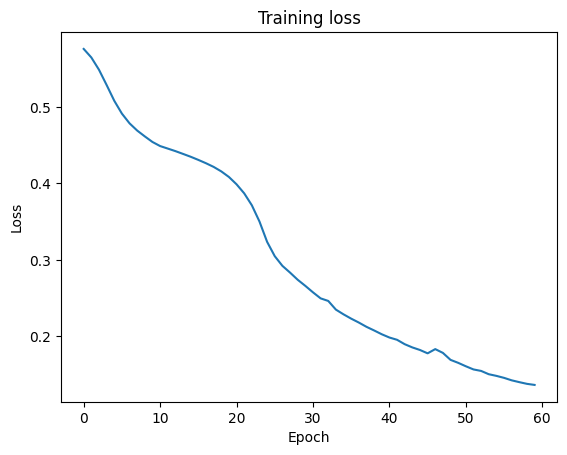

In [17]:
plt.plot(losses)
plt.title('Training loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Testing the model

We first check the accuracy.

In [18]:
# testing
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs, _ = model(inputs)
        predicted = torch.round(outputs)
        # print(predicted.sum(), labels.sum())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test set: %d %%' % (100 * correct / total))

Accuracy of the network on the test set: 91 %


However, accuracy isn't the only meaningful metric. As a result, we compute the confusion matrix below.

What do the confusion matrix entries mean?

(0,0): True Negative Values

(0,1): False Positive Values

(1,0): False Negative Values

(1,1): True Positive Values

Precision = (True Positive) / (True Positive + False Positive)

Recall = (True Positive) / (True Positive + False Negative)

F1-Score = 2 * precision * recall / (precision + recall)

Notice that precision gives emphasis to what the model deemed as positive (the target class, a spam email in our case). It doesn't consider the number of times we fail to identify a truly spam email - the False Negatives. Instead, it indicates the number of times our model is right when it views an email as spam. This gap is filled by recall, whose denominator has the number of False Negatives, thus this metric indicates how good our model is to identify a truly spam email.

In [19]:
# confusion matrix
confusion = torch.zeros(2, 2)
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs, _ = model(inputs)
        predicted = torch.round(outputs)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
            confusion[t.long(), p.long()] += 1

print(confusion)

tensor([[418.,  34.],
        [ 17., 162.]])


In [20]:
precision = confusion[1, 1] / (confusion[1, 1] + confusion[0, 1])
recall = confusion[1, 1] / (confusion[1, 1] + confusion[1, 0])
f1 = 2 * precision * recall / (precision + recall)
print('Precision: %d%%' % (round((precision.item())*100)))
print('Recall: %d%%' % round(recall.item()*100))
print('F1 score: %d%%' % (round(f1.item()*100)))

Precision: 83%
Recall: 91%
F1 score: 86%


Our accuracy, precision, recall, and F1 score values are indicative of our successful training. There is obviously room for improvement.

In [21]:
print('The percentage of spam emails in the training dataset is %.1f%% while the percentage of spam emails in the testing dataset is %.1f%%.' %((train_labels.sum()/len(train_labels)).item()*100, (test_labels.sum()/len(test_labels)).item()*100))

The percentage of spam emails in the training dataset is 27.0% while the percentage of spam emails in the testing dataset is 28.4%.


Because the percentage of spam emails is approximately 28% in both training and testing datasets, we want out model to be at least 72% accurate. 

During my first attempts, my dataset wasn't balanced (82% non-spam, 18% spam) and my model would only predict "0" as the output. In that case, the 82% accuracy result was very misleading. It wasn't an indication of successful training, despite the high accuracy score. On the other hand, precision and recall were both 0, since there were no true positives. As a result, I had to balance my dataset by ignoring some of the non-spam emails.

In [22]:
# save the model
torch.save(model.state_dict(), 'model.pth')
print('Model saved')

Model saved
